In [79]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate 50 invoices

Anything more will render a graph too large to be legible.


In [80]:
# Expose invoice simulator to notebook
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent / "src"))

# init invoice simulator
from src.invoices.invoice_simulator import InvoiceSimulator

simulator = InvoiceSimulator(n_companies=10)
invoices = simulator.generate_invoices(30)

In [81]:
# check company credit scores
# simulator.company_credit_scores

In [82]:
# Assign company credit scores
import pandas as pd

invoices_df = pd.DataFrame(invoices).assign(
    buyer_credit_score=lambda df: df["buyer_company"].map(
        simulator.company_credit_scores
    ),
    seller_credit_score=lambda df: df["seller_company"].map(
        simulator.company_credit_scores
    ),
)

In [83]:
nodes = {k: dict(credit_score=v) for k, v in simulator.company_credit_scores.items()}

df_nodes = pd.DataFrame.from_dict(nodes, orient="index")

# Buyer and Seller Summary Statistics


In [84]:
invoices_df.groupby("buyer_company").agg(
    n=("invoice_id", "size"),
    total_value=("invoice_amount", "sum"),
    n_sellers=("seller_company", lambda x: len(x.unique())),
)

,n,total_value,n_sellers
buyer_company,,,
CV Pratiwi,5,2450,3
PD Yulianti Hutapea,8,4150,4
PT Sudiati,4,2550,2
Perum Nurdiyanti Farida Tbk,4,2000,3
UD Oktaviani Dabukke (Persero) Tbk,4,2600,3
UD Wasita Tbk,5,2650,3


In [85]:
invoices_df.groupby("seller_company").agg(
    n=("invoice_id", "size"),
    total_value=("invoice_amount", "sum"),
    n_sellers=("buyer_company", lambda x: len(x.unique())),
)

,n,total_value,n_sellers
seller_company,,,
CV Waluyo (Persero) Tbk,5,2000,3
PT Siregar (Persero) Tbk,9,4600,4
Perum Maheswara Nuraini (Persero) Tbk,6,3850,5
UD Melani Melani,9,5800,5
UD Wasita Tbk,1,150,1


# Graph 1: Simple Graph - Generate a graph from this simulated invoices

Since the graph only recognizes the nodes at the company level. We need to aggregate the invoices_df to the buyer-seller level.


In [86]:
relationship_df = (
    invoices_df.groupby(["buyer_company", "seller_company"])
    .agg(n=("invoice_id", "count"), total_amount=("invoice_amount", "sum"))
    .reset_index()
)

display(relationship_df)

,buyer_company,seller_company,n,total_amount
0,CV Pratiwi,CV Waluyo (Persero) Tbk,1,500
1,CV Pratiwi,PT Siregar (Persero) Tbk,3,1250
2,CV Pratiwi,UD Melani Melani,1,700
3,PD Yulianti Hutapea,CV Waluyo (Persero) Tbk,2,1000
4,PD Yulianti Hutapea,PT Siregar (Persero) Tbk,2,700
5,PD Yulianti Hutapea,Perum Maheswara Nuraini (Persero) Tbk,1,500
6,PD Yulianti Hutapea,UD Melani Melani,3,1950
7,PT Sudiati,PT Siregar (Persero) Tbk,2,1550
8,PT Sudiati,Perum Maheswara Nuraini (Persero) Tbk,2,1000
9,Perum Nurdiyanti Farida Tbk,Perum Maheswara Nuraini (Persero) Tbk,1,900


In [87]:
# load into the graph

import networkx as nx

# init empty graph
G = nx.Graph()

# Add edges (and hence nodes) by iterating through the relationship df
G.add_edges_from(
    [
        (r.buyer_company, r.seller_company, {"n": r.n, "total_amount": r.total_amount})
        for r in relationship_df.itertuples()
    ]
)

# Update node attributes with credit scores
G.add_nodes_from(
    [
        (company_name, {"credit_score": credit_score})
        for company_name, credit_score in simulator.company_credit_scores.items()
    ]
)

In [88]:
# scale the edge width
amounts = []
for e, eattr in G.edges.items():
    amounts.append(eattr["total_amount"])

x_max = max(amounts)
x_min = min(amounts)
scaled_amounts = list(map(lambda x: (x - x_min) / (x_max - x_min), amounts))

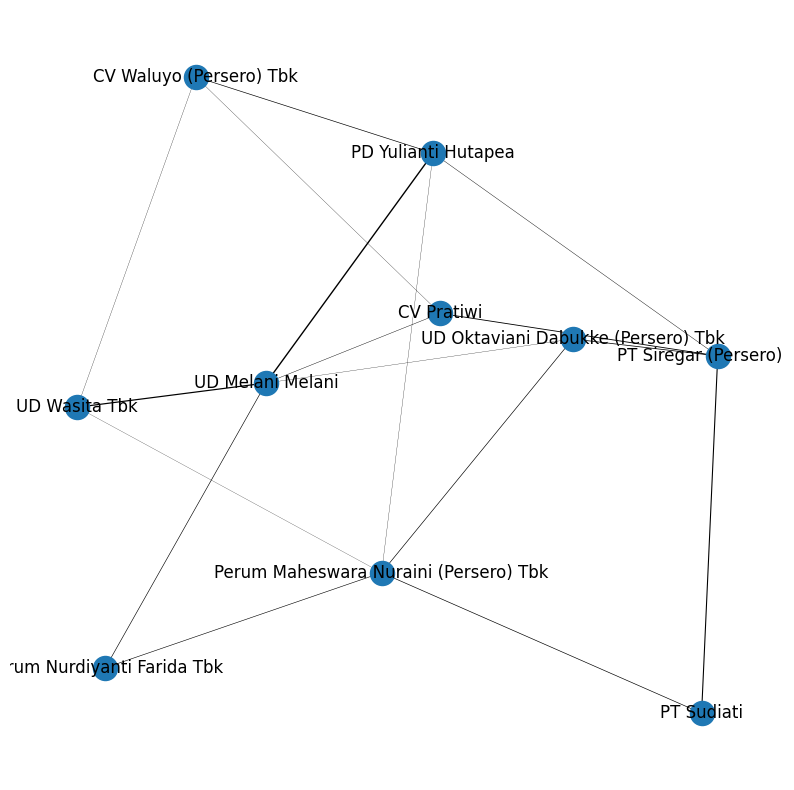

In [89]:
# visualize the graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(G, pos=nx.spring_layout(G), with_labels=True, width=scaled_amounts, ax=ax)

# Graph 2: A structured approach to constructing the graph

1. Here, we load all possible nodes (companies) into the graphs first:


In [90]:
import networkx as nx


# Init Graph by loading edges (relationship) from the relationship_df
G = nx.from_pandas_edgelist(
    relationship_df, "seller_company", "buyer_company", ["n", "total_amount"]
)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


# Append node attributes (credit scores)
G.add_nodes_from(
    [
        (node, dict(credit_score=credit_score))
        for node, credit_score in simulator.company_credit_scores.items()
    ]
)

Number of nodes: 10
Number of edges: 18


(np.float64(-0.593969823831037),
 np.float64(1.151463195929646),
 np.float64(-0.8985363336066782),
 np.float64(0.833977122215128))

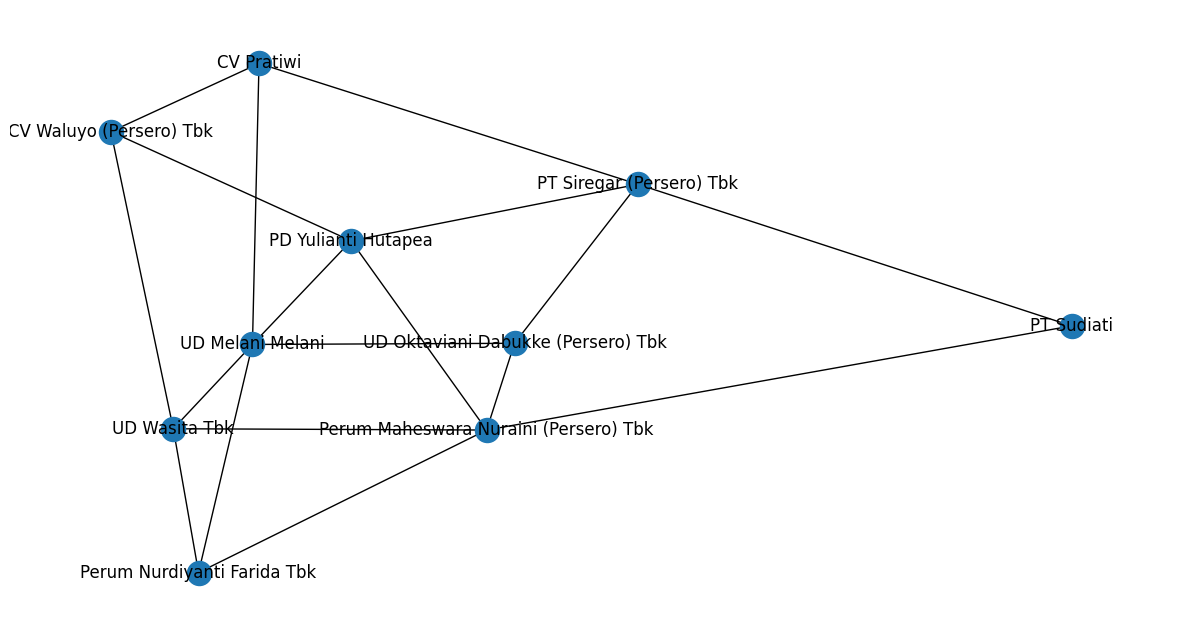

In [91]:
# Plot out Graph without any weighting
fig, ax = plt.subplots(figsize=(15, 8))
nx.draw_networkx(G, pos=nx.spectral_layout(G))
plt.axis("off")

[('UD Melani Melani', 0.5555555555555556), ('Perum Maheswara Nuraini (Persero) Tbk', 0.5555555555555556), ('PT Siregar (Persero) Tbk', 0.4444444444444444)]


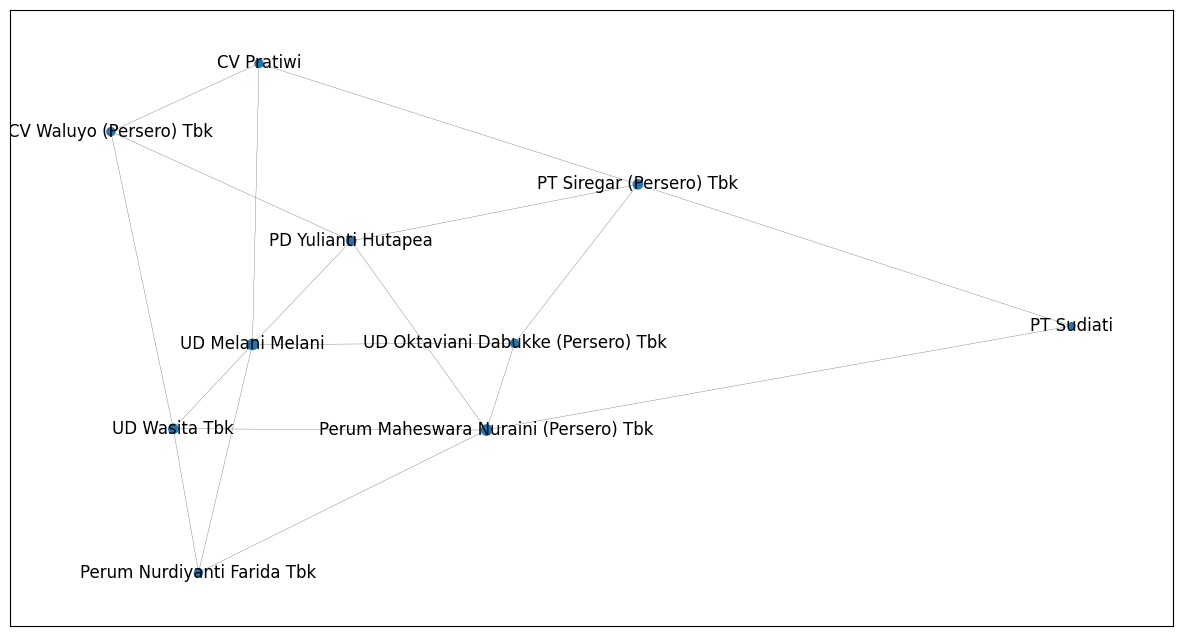

In [92]:
# Measure the degree centrality of each node in this graph
degree_centrality = nx.centrality.degree_centrality(G)

# Top 3 companies by degree centrality
print(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:3])

# Plot
fig, ax = plt.subplots(figsize=(15, 8))
node_size = [v * 100 for v in degree_centrality.values()]
nx.draw_networkx(G, pos=nx.spectral_layout(G), node_size=node_size, width=0.15)

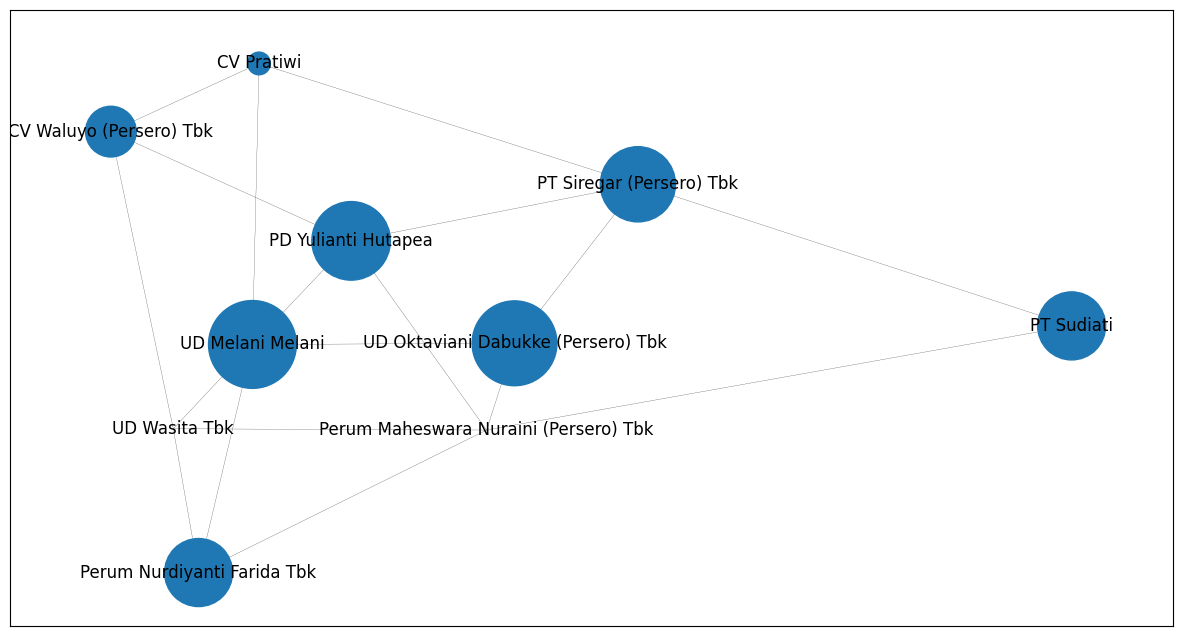

In [93]:
# Plot node size based on the credit score
import numpy as np

fig, ax = plt.subplots(figsize=(15, 8))

credit_scores = np.array(
    [credit_score for _, credit_score in G.nodes(data="credit_score")]
)
scaled_credit_scores = (credit_scores - min(credit_scores)) / (
    max(credit_scores) - min(credit_scores)
)
nx.draw_networkx(
    G, pos=nx.spectral_layout(G), node_size=scaled_credit_scores * 4000, width=0.15
)

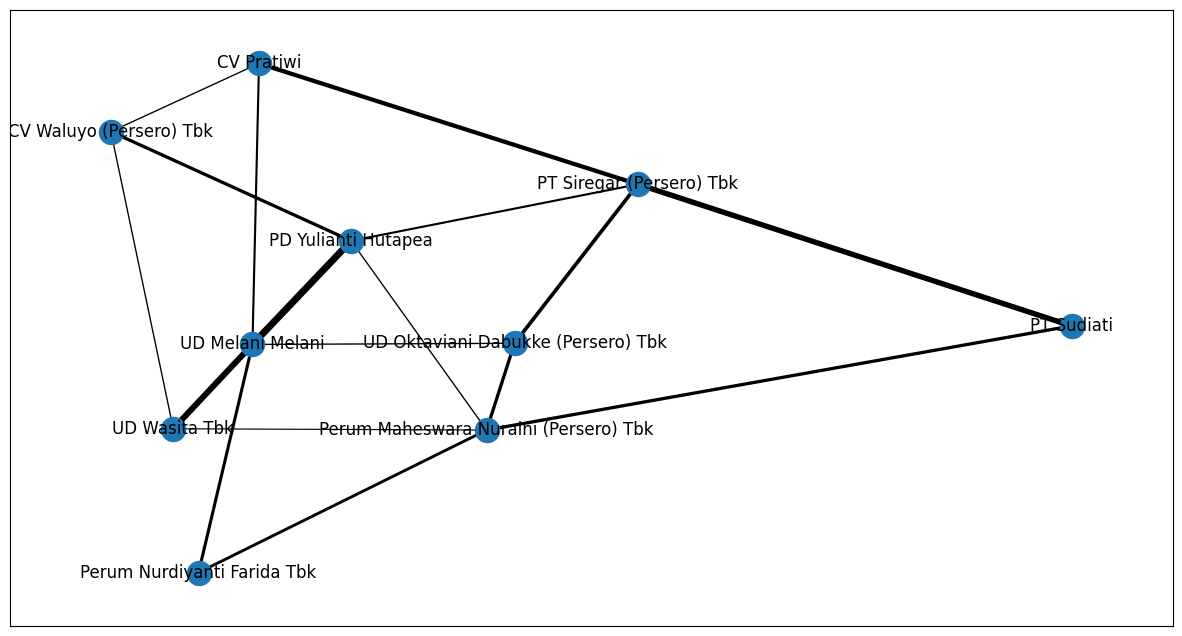

In [94]:
# Plot edge size based on the total transactional value of the partnership
fig, ax = plt.subplots(figsize=(15, 8))

transaction_values = np.array([et for u, v, et in G.edges(data="total_amount")])
scaled_transaction_values = (transaction_values - min(transaction_values)) / (
    max(transaction_values) - min(transaction_values)
)
nx.draw_networkx(G, pos=nx.spectral_layout(G), width=scaled_transaction_values * 5)

## Network weighted scores

With the graph structure in place, we can easily back out the adjency matrix to cater for user-defined metrics.


In [95]:
# Create adjency matrix with transaction amount as the weight, normalized across each node.
P, nodes = nx.attr_matrix(G, edge_attr="total_amount", normalized=True)

y = np.array(list(n[1] for n in G.nodes(data="credit_score"))).reshape(-1, 1)

# P.y
metric = P @ y
metric

array([[518.96551724],
       [659.23913043],
       [601.62337662],
       [523.03921569],
       [540.38461538],
       [600.        ],
       [519.89795918],
       [582.58928571],
       [580.42168675],
       [512.5       ]])

Our current method allows us to weight credit scores by volume, but it falls short when we need to factor in the type of transaction. For example, determining a company's buyer exposure necessitates focusing only on the transaction value of sales. The undirected nature of our current graph model means we lose the critical 'buy-sell' direction. To accurately incorporate this contextual information, we will transition to a Directed Graph (DiGraph) model, which we'll discuss in detail next.


# Graph 3: Directed Graphs (DiGraph)


In [96]:
import networkx as nx


# Init Graph by loading edges (relationship) from the relationship_df
G = nx.from_pandas_edgelist(
    relationship_df,
    "seller_company",
    "buyer_company",
    ["n", "total_amount"],
    create_using=nx.DiGraph(),  # instantiate using a DiGraph
)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


# Append node attributes (credit scores)
G.add_nodes_from(
    [
        (node, dict(credit_score=credit_score))
        for node, credit_score in simulator.company_credit_scores.items()
    ]
)

Number of nodes: 10
Number of edges: 18


Notice that we have more edges compared to the undirected graph? 33 --> 39. This is because the graph differentiates the buyer seller context. Previously the graph was agnostic to this context.


(np.float64(-0.593969823831037),
 np.float64(1.151463195929646),
 np.float64(-0.8985363336066782),
 np.float64(0.833977122215128))

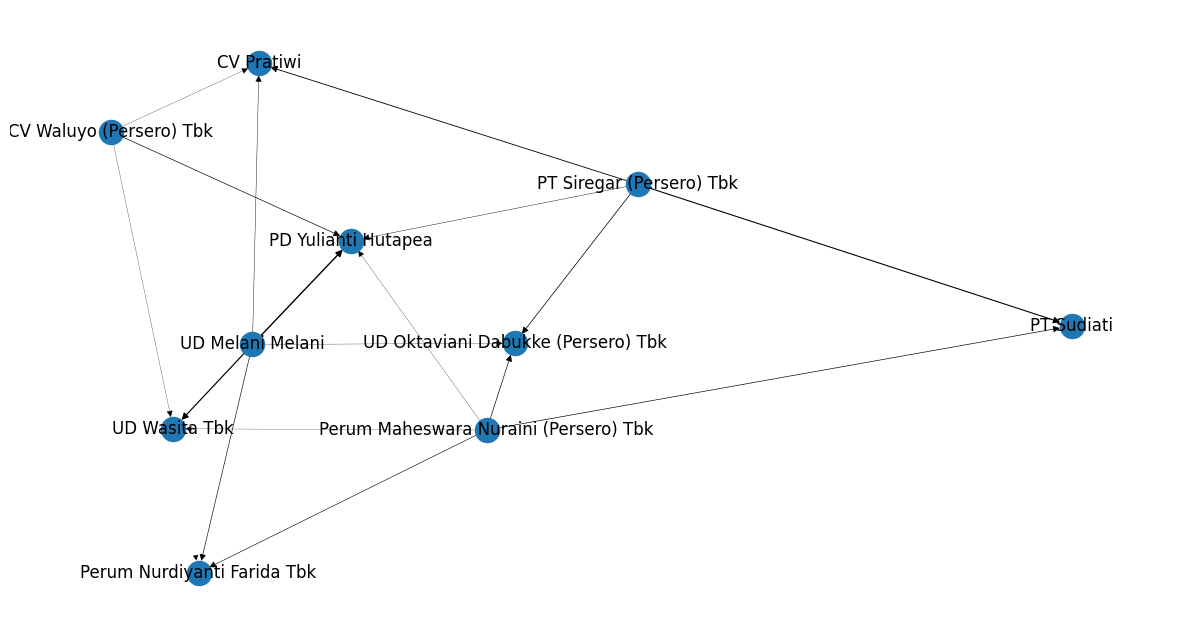

In [97]:
# Plot edge size based on the total transactional value of the partnership
fig, ax = plt.subplots(figsize=(15, 8))

transaction_values = np.array([et for u, v, et in G.edges(data="total_amount")])
scaled_transaction_values = (transaction_values - min(transaction_values)) / (
    max(transaction_values) - min(transaction_values)
)
nx.draw_networkx(G, pos=nx.spectral_layout(G), width=scaled_transaction_values)
plt.axis("off")

(np.float64(-0.593969823831037),
 np.float64(1.151463195929646),
 np.float64(-0.8985363336066782),
 np.float64(0.833977122215128))

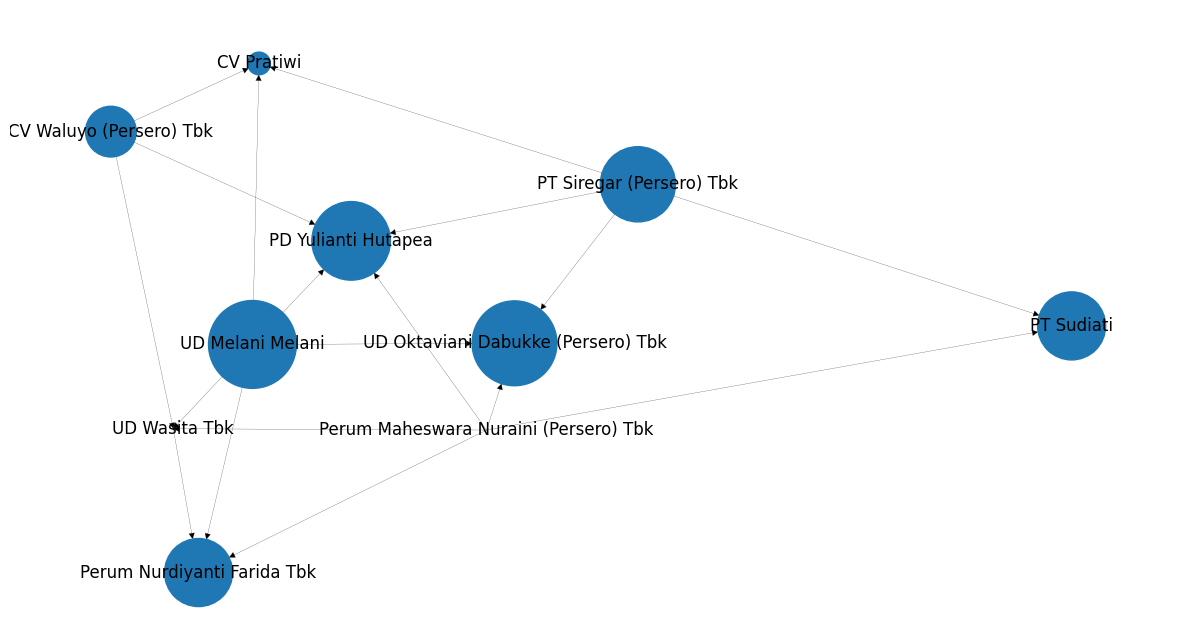

In [98]:
# Plot node size based on the credit score
import numpy as np

fig, ax = plt.subplots(figsize=(15, 8))

credit_scores = np.array(
    [credit_score for _, credit_score in G.nodes(data="credit_score")]
)
scaled_credit_scores = (credit_scores - min(credit_scores)) / (
    max(credit_scores) - min(credit_scores)
)
nx.draw_networkx(
    G, pos=nx.spectral_layout(G), node_size=scaled_credit_scores * 4000, width=0.15
)
plt.axis("off")

In [99]:
print(f"{G.in_degree('CV Kuswoyo Tbk')=}")
print(f"{G.out_degree('CV Kuswoyo Tbk')=}")
print(f"{G.degree('CV Kuswoyo Tbk')=}")


G.in_degree('CV Kuswoyo Tbk')=InDegreeView({})
G.out_degree('CV Kuswoyo Tbk')=OutDegreeView({})
G.degree('CV Kuswoyo Tbk')=DiDegreeView({})


## Direction-aware weighting

With a DiGraph, we are able to segment the graph based on the direction of the relationship. In OP case, we weight metrics based on sales only transaction (out edges), to measure buyer-only exposure. For example, volume weighted credit scores from the buyers.


This can be done by filtering the graph down to the out edges. Conveniently, NetworkX provides the out_edges property to achieve this subgraph view.

We can specify `data=True` or `data='<edge_attr>'`, to include edge attributes into the subgraph.

We can then materialize a new subgraph, using the out edges. The reason why we have to do this is because NetworkX does not allow extracting adjacency matrix from GraphViews.


In [100]:
# Get the out edges
out_edges = G.out_edges

# Make new subgraph of outedges
OutGraph = G.edge_subgraph(out_edges)
# list(OutGraph.edges(data=True))[:5]


In [101]:
P, nodes = nx.attr_matrix(OutGraph, edge_attr="total_amount", normalized=True)
y = list(simulator.company_credit_scores.values())
scores = P @ y

pd.DataFrame(np.round(scores, 2), index=nodes, columns=["Average Buyer Rating"])

/home/aaron/projects/online-pajak/playground/trade-network-streamlit/.venv/lib/python3.12/site-packages/networkx/linalg/attrmatrix.py:303: RuntimeWarning: invalid value encountered in divide
  M /= M.sum(axis=1).reshape((N, 1))


,Average Buyer Rating
UD Melani Melani,674.14
PT Siregar (Persero) Tbk,660.87
Perum Maheswara Nuraini (Persero) Tbk,619.16
PT Sudiati,NaN
UD Oktaviani Dabukke (Persero) Tbk,NaN
Perum Nurdiyanti Farida Tbk,NaN
CV Pratiwi,NaN
UD Wasita Tbk,400.00
PD Yulianti Hutapea,NaN
CV Waluyo (Persero) Tbk,725.00


## Betweenness Centrality weighted by Transaction value


In [102]:
weighted_centrality = nx.centrality.betweenness_centrality(
    OutGraph,  # weight="total_amount"
)
avg_bc = sum(weighted_centrality.values()) / len(OutGraph.nodes)

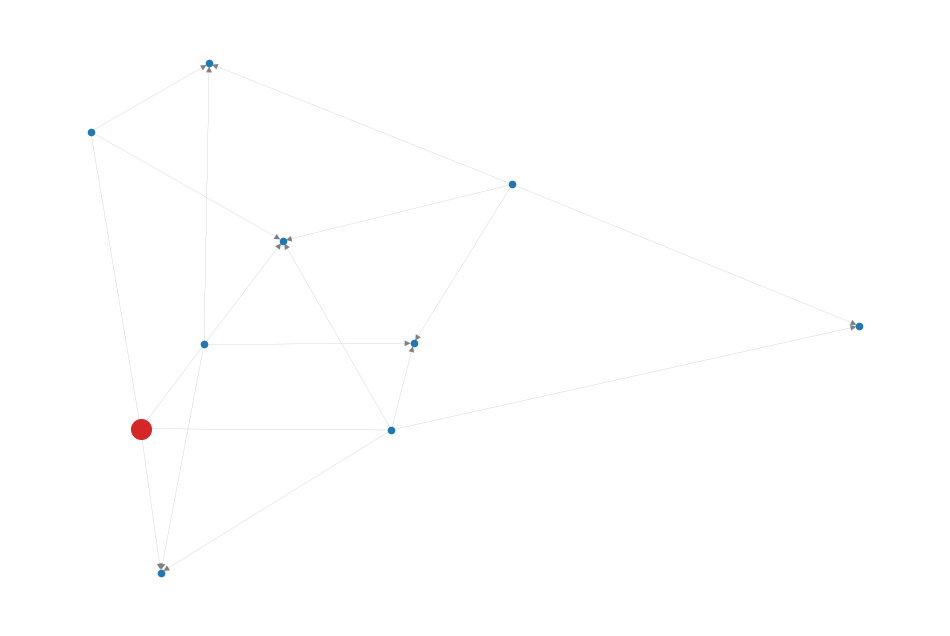

In [103]:
# Plot node size based on the weighted betweenness centrality
node_size = [v * 4e3 for v in weighted_centrality.values()]
has_high_centrality = [n for n, v in weighted_centrality.items() if v >= avg_bc]

fig, ax = plt.subplots(figsize=(12, 8))
plt.axis("off")

options = {
    "node_color": "tab:blue",
    "node_size": 20,
    "edge_color": "tab:grey",
    "width": 0.1,
}

# Draw baseline graph
pos = nx.spectral_layout(OutGraph)
nx.draw(OutGraph, pos=pos, **options)

# Update node with high centrality
nx.draw_networkx_nodes(
    OutGraph,
    pos=pos,
    nodelist=has_high_centrality,
    node_color="tab:red",
    node_size=200,
)
plt.show()

In [104]:
import json
from pathlib import Path
import networkx as nx
import os


def graph2json(G, filename: str | Path) -> None:
    """Serializes a NetworkX graph to a JSON file in node-link format.

    This function takes a NetworkX graph object and serializes it into
    a JSON file using the node-link data format, which is easily
    interpretable by many graph visualization libraries and tools.

    Args:
        G (networkx.Graph): The NetworkX graph object to be serialized.
        filename (str | Path): The path to the output JSON file. Can be a string
                                or a pathlib.Path object.

    Returns:
        None: The function writes the serialized graph to the specified file
              and does not return any value.

    Raises:
        TypeError: If 'G' is not a NetworkX graph object.
        IOError: If there's an issue writing to the specified 'filename'.

    Examples:
        >>> import networkx as nx
        >>> from pathlib import Path
        >>> import json
        >>>
        >>> # Create a simple NetworkX graph
        >>> G_example = nx.Graph()
        >>> G_example.add_edges_from([(1, 2), (2, 3), (3, 1)])
        >>> G_example.nodes[1]['name'] = 'Node A'
        >>> G_example.nodes[2]['name'] = 'Node B'
        >>>
        >>> # Define a temporary filename for the example
        >>> output_file = Path("example_graph.json")
        >>>
        >>> # Serialize the graph to JSON
        >>> graph2json(G_example, output_file)
        >>>
        >>> # Verify the content of the created file (optional)
        >>> with open(output_file, 'r') as f:
        >>>     data = json.load(f)
        >>> print(data['nodes'][0]['id']) # Should print 1
        1
        >>>
        >>> # Clean up the created file
        >>> output_file.unlink()
    """
    # Serialize the graph, G in node link format, which is JSON serializable.
    serialized = json.dumps(G, default=lambda o: nx.node_link_data(o, edges="edges"))

    # Write to file
    with open(filename, "w") as file:
        file.write(serialized)

    # File size (in MB)
    fs = os.path.getsize(filename) / 1024 / 1024
    print(f"File size: {fs:.2f} MB")

In [105]:
graph2json(OutGraph, "graph.json")

File size: 0.00 MB
